# Exploring the Connection between Robust and Generative Models

**Experiments of HE-PGD on imagentte with ResNet**

In [1]:
# INSTALL LIBRARY FOR G-CNNS
! pip install numpy scipy matplotlib nose
! pip install ipywidgets

! pip install torchattacks
! pip install netcal

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch
import numpy as np
import sklearn
import scipy
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from typing import *
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torch.nn import functional as F
from torch.nn import Conv2d
from torch.nn import MaxPool2d as MaxPool2d
from tqdm import tqdm
import torchvision.models as models
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

# Reproducibility stuff

In [3]:
#REPRODUCIABILYT STUFF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

import random
import numpy as np
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.cuda.manual_seed(0)

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 5000})

Using device: cuda:0


# Dataset imagenette

**To download the dataset Imagenette uncomment the following cells**
**Pay attention about the pathfile you want to save the datasets**

In [4]:
#! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

In [5]:
# Unzip raw zip file
#! mkdir imagenette
#! tar -xzvf 'imagenette2-160.tgz' -C '/notebooks/imagenette'

# Data Processing

In [17]:
from torch.utils.data import random_split


means = [0.491, 0.482, 0.446]   #mean = [0.485, 0.456, 0.406]
std = [0.202, 0.199, 0.201]     #std = [0.229, 0.224, 0.225]

transform_train2 = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize(means, std),
])

transform_test2 = transforms.Compose([

    transforms.CenterCrop(150),
    transforms.ToTensor(),
    
])



trainset_imagenette = torchvision.datasets.ImageFolder("/notebooks/imagenette/imagenette2-160/train", transform=transform_train2)
testset_imagenette = torchvision.datasets.ImageFolder("/notebooks/imagenette/imagenette2-160/val", transform=transform_test2)


train_set_imagenette, val_set_imagenette = torch.utils.data.random_split(trainset_imagenette, [8969,500])


#create the dataloaders
train_loader_imagenette = torch.utils.data.DataLoader(train_set_imagenette, batch_size=64, shuffle=True, num_workers=10)
val_loader_imagenette = torch.utils.data.DataLoader(val_set_imagenette, batch_size=32, shuffle=True, num_workers=10)
test_loader_imagenette = torch.utils.data.DataLoader(testset_imagenette, batch_size=32, shuffle=False, num_workers=5)

##############################################################################################################

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
print(next(iter(test_loader_imagenette)))

[tensor([[[[0.1961, 0.4549, 0.3294,  ..., 0.5059, 0.5176, 0.5255],
          [0.2588, 0.2353, 0.3294,  ..., 0.4824, 0.4863, 0.4902],
          [0.2392, 0.1686, 0.2667,  ..., 0.4667, 0.4627, 0.4667],
          ...,
          [0.7843, 0.7765, 0.7373,  ..., 0.6000, 0.5961, 0.5647],
          [0.7255, 0.7843, 0.7686,  ..., 0.6275, 0.6157, 0.5490],
          [0.7020, 0.7922, 0.7765,  ..., 0.6627, 0.6275, 0.5216]],

         [[0.3373, 0.5725, 0.4392,  ..., 0.5529, 0.5647, 0.5686],
          [0.4039, 0.3647, 0.4471,  ..., 0.5294, 0.5333, 0.5333],
          [0.3843, 0.2980, 0.3843,  ..., 0.5137, 0.5098, 0.5137],
          ...,
          [0.7725, 0.7647, 0.7255,  ..., 0.6039, 0.6000, 0.5725],
          [0.7137, 0.7725, 0.7569,  ..., 0.6314, 0.6196, 0.5569],
          [0.6902, 0.7804, 0.7686,  ..., 0.6667, 0.6314, 0.5294]],

         [[0.0627, 0.3608, 0.2510,  ..., 0.5451, 0.5647, 0.5765],
          [0.1294, 0.1412, 0.2510,  ..., 0.5216, 0.5333, 0.5412],
          [0.1098, 0.0745, 0.1804,  ..., 

# Utility Functions

In [19]:
from tqdm import tqdm
import torchattacks
import torch.nn.functional as F

best_acc = 0  # best test accuracy


# Clean Training
def train(epoch, loader , net, optimizer, loss_func, log_freq):

    net.train()
    running_loss=0
    correct = 0
    total = 0
    losses = []

    for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
        
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = loss_func(outputs, targets)

        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()
        
        # print statistics every log_freq mini batch
        if (batch_idx+1) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, batch_idx, running_loss / log_freq))
            losses.append( running_loss / log_freq)
            running_loss = 0.0
            print('Top1 Accuracy of the network on the trainset images:', correct / total)
            correct=0
            total=0
        
    return losses



# validation clean images
def validation(i, net, loader, loss_func, url_name_model):

    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0
    folder_save = url_name_model

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = net(inputs)
            loss = loss_func(outputs, targets)

            test_loss += loss.item()

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()
        
        print('Top1 accuracy of the network on the normal validation set:', 100.*correct / total)
        print('Top3 accuracy of the network on the normal validation set:', 100.*correct3 / total)
        print('Top5 accuracy of the network on the normal validation set:', 100.*correct5 / total)

        # Save checkpoint.
        acc = 100.*correct/total
        if acc > best_acc:
            print('Saving..')
            torch.save({
                'epoch': i,
                'model_state_dict': net.state_dict(),
                }, folder_save)
            best_acc = acc

            
            
# testing clean images
def testing(net, loader):
    
    net.eval()
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            
            outputs = net(inputs)

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()

                
        print('Top1 accuracy of the network on the normal test set:', 100.*correct / total)
        print('Top3 accuracy of the network on the normal test set:', 100.*correct3 / total)
        print('Top5 accuracy of the network on the normal test set:', 100.*correct5 / total)


         

def energy_loss(output, target, gamma):
    
    loss = nn.CrossEntropyLoss()(output,target) +  gamma * ( - torch.mean(torch.log(torch.sum(torch.exp(output),dim=1))))
    
    return loss



def PGD_high_energy(model, images, labels, eps=8/255, alpha=1/255, steps=5, gamma=0.5, random_start=True):

        images = images.clone().detach().to(device)
        labels = labels.clone().detach().to(device)

        adv_images = images.clone().detach()

        if random_start:
            
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(-eps, eps)
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(steps):
            
            adv_images.requires_grad = True
            outputs = model(adv_images)

            # Calculate loss
            cost = energy_loss(outputs, labels, gamma)

            # Update adversarial images
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + alpha*grad.sign()
            delta = torch.clamp(adv_images - images, min=-eps, max=eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()
        
        return adv_images


    
    
def test_robustness_HEPGD(model, loader, epsilon, alpha, steps, factor, printt=True):
        """
            test robustness with HE-PGD 
        """
        correct = 0
        test_loss_adv = 0
        correct_adv = 0
        loss_func = nn.CrossEntropyLoss()
        
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            adv_images = PGD_high_energy(model, data, target, eps=epsilon, alpha=alpha, steps=steps, gamma=factor, random_start=True)
            output_adv = model(adv_images)
            
            _, predicted = torch.max(output_adv.data, 1)
            correct_adv += predicted.eq(target.data).cpu().sum().item()
            
        if printt == True:
            print('Adv Accuracy: {}/{} ({:.0f}%)\n'.format(
                 correct_adv, len(loader.dataset),
                100. * correct_adv / len(loader.dataset)))
            
        

def test_robustness_PGD(model, loader, epsilon, alpha, steps, printt=True):
        """
            test robustness with PGD 
        """
        atk = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)
        #atk.set_normalization_used(mean=means, std=std)
        
        correct = 0
        test_loss_adv = 0
        correct_adv = 0
        loss_func = nn.CrossEntropyLoss()
        
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            data_adv = atk(data, target)
            import torch.nn.functional as F
            output_adv = model(data_adv)
            _, predicted = torch.max(output_adv.data, 1)
            correct_adv += predicted.eq(target.data).cpu().sum().item()
            
        if printt == True:
            print('Adv Accuracy: {}/{} ({:.0f}%)\n'.format(
                 correct_adv, len(loader.dataset),
                100. * correct_adv / len(loader.dataset)))
        
        
    
def compute_logit(model, loader, epsilon, steps):
        """
            It computes the logit of clean and adversarial (standard PGD) data
        """
        logit_adv = []
        logit_or = []
        ground = []
        model.eval()
        
        atk = torchattacks.PGD(model, eps=epsilon, alpha=1/255, steps=steps)
        #atk.set_normalization_used(mean=means, std=std)
        
        for data, target in loader:
            
            model.eval()
            data, target = data.to(device), target.to(device)
            
            #origianl clean data
            output_original = model(data)
            
            #adv data
            data_adv = atk(data, target)
            output_adv = model(data_adv)
            
            #get confidences
            logit_adv.append(output_adv.data)
            logit_or.append(output_original.data)
            ground.append(target)
                   
        logit_adv = torch.cat([t for t in logit_adv], dim=0).cpu().numpy()
        logit_or = torch.cat([t for t in logit_or], dim=0).cpu().numpy()
        ground = torch.cat([t for t in ground], dim=0)
        
        #compute also the energy
        energy_adv =  - np.log( np.sum(np.exp(logit_adv,dtype=np.float128),1) )
        energy_or = - np.log( np.sum(np.exp(logit_or,dtype=np.float128),1) )
        confidences_adv = F.softmax(torch.Tensor(logit_adv),dim=1)
            
        return confidences_adv.cpu().numpy(), ground.cpu().numpy(), logit_or, logit_adv, energy_or, energy_adv
    
    
    
    
def compute_logit_HEPGD(model, loader, epsilon, steps, factor):
        """
            compute the logit of clean and adversarial (HE-PGD) data
        """
        logit_adv = []
        logit_or = []
        ground = []
        
        for data, target in loader:
            
            model.eval()
            data, target = data.to(device), target.to(device)
            
            #origianl clean data
            output_original = model(data)
            
            #adv data
            data_adv = PGD_high_energy(model, data, target, eps=epsilon, alpha=1/255, steps=steps, gamma=factor, random_start=True)
            output_adv = model(data_adv)
            
            #get confidences
            logit_adv.append(output_adv.data)
            logit_or.append(output_original.data)
            ground.append(target)
                   
        logit_adv = torch.cat([t for t in logit_adv], dim=0).cpu().numpy()
        logit_or = torch.cat([t for t in logit_or], dim=0).cpu().numpy()
        ground = torch.cat([t for t in ground], dim=0)
        
        energy_adv =  - np.log(np.sum(np.exp(logit_adv,dtype=np.float128),1))
        energy_or = - np.log(np.sum(np.exp(logit_or,dtype=np.float128),1))
        confidences_adv = F.softmax(torch.Tensor(logit_adv),dim=1)
            
        return confidences_adv.cpu().numpy(), ground.cpu().numpy(), logit_or, logit_adv, energy_or, energy_adv
    

In [20]:
import ResNet_imagenette
from torch.optim.lr_scheduler import ExponentialLR, LinearLR, MultiStepLR

net1 = nn.Sequential(
    
    ResNet_imagenette.ResNet10(10,True)
).to(device)

training = False 


if training : 
    
    net1 = net1.eval()
    print(count_parameters(net1))

    #hyper-params
    epsilon = 8/255
    steps = 5
    step_size = 2/255

    epochs = 60
    learning_rate = 0.001
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net1.parameters(), lr=learning_rate, weight_decay=5e-4)
    loss_value = []



    scheduler = MultiStepLR(optimizer, milestones=[30], gamma=0.10)



    for i in range(epochs):
        loss_avg = train(epoch=i, loader=train_loader_imagenette, net=net1, optimizer=optimizer, loss_func=loss_func, log_freq=250)
        #loss_avg = adversarial_training_pgd(epoch=i, loader=train_loader_imagenette, net=net1, optimizer=optimizer, loss_func=loss_func, log_freq=100, epsilon=epsilon, steps = steps, step_size = step_size)
        validation(i, net1, val_loader_imagenette, loss_func, "/notebooks/models_imagenette_perspective/ResNet10_imagenette_Simple_train_MSLR30.pt" )
        scheduler.step()
        loss_value.append(loss_avg)


    #plot training loss
    y_ax = np.reshape(loss_value, (-1))
    x = range(len(y_ax))
    plt.plot(x,  y_ax)


# Model

**load the models if already exists. Define a normalize layer to align test data to the training normalization**

In [21]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

#model
norm_layer = Normalize(mean=means, std=std)

In [22]:
model1 = nn.Sequential(
    ResNet_imagenette.ResNet10(10,True)
).to(device)

# Load Base Model
checkpoint = torch.load("/notebooks/models_imagenette_perspective/ResNet10_imagenette_Simple_train_MSLR30.pt")
model1.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])



# MODEL with the norm layer
model_norm = nn.Sequential(norm_layer, model1).to(device)



model2 = nn.Sequential(
    norm_layer,
    ResNet_imagenette.ResNet10(10,True)
).to(device)

# Test Base Model
learning_rate = 0.001
checkpoint = torch.load("/notebooks/models_imagenette_Gaussian/ResNet10_imagenette_NOGaussian.pt")
model2.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['epoch'])


57
31


# Logit and Energy Function Analysis

In [23]:
import numpy as np
from netcal.scaling import TemperatureScaling
from netcal.metrics import ECE, MCE
from netcal.presentation import ReliabilityDiagram
from matplotlib import pyplot as plt
import matplotlib


SMALL_SIZE = 20
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title




def plot_energy_PGD(model, loader, epsilon, steps, bins, name):
    
    _,_,_,_, energy_clean, energy_adversarial = compute_logit(model.to(device), loader, epsilon, steps)
    
    x = np.stack((energy_clean, energy_adversarial),axis=1)
    fig, ax = plt.subplots(figsize =(7, 5))
    ax.set_ylim(0,780)
    
    ax.hist(x, bins=np.linspace(-70,10, bins), histtype='bar' , color=['lightblue','red'], label=["clean data", 'adversarial data'], stacked=False )

    ax.set_xlabel('E(x)', fontsize=27)
    ax.set_ylabel('# samples',  fontsize=27)
    plt.legend(loc='upper left', fontsize=20)
    fig.set_size_inches(8, 6)
    plt.show()
    fig.savefig(name, format='pdf',bbox_inches='tight')
    
    

def plot_energy_HEPGD(model, loader, epsilon, steps, bins, factor, name):
    
    _,_,_,_, energy_clean, energy_adversarial = compute_logit_HEPGD(model.to(device), loader, epsilon, steps, factor)
    
    x = np.stack((energy_clean, energy_adversarial),axis=1)
    fig, ax = plt.subplots(figsize =(7, 5))
    ax.set_ylim(0,780)
    
    ax.hist(x, bins=np.linspace(-70,10, bins), histtype='bar' , color=['lightblue','red'], label=["clean data", 'adversarial data'], stacked=False )

    ax.set_xlabel('E(x)', fontsize=27)
    ax.set_ylabel('# samples',  fontsize=27)
    plt.legend(loc='upper left', fontsize=20)
    fig.set_size_inches(8, 6)
    plt.show()
    fig.savefig(name, format='pdf',bbox_inches='tight')
    
    

def plot_energy_PGD_steps(model, loader, epsilon, steps, name):
    
    '''
    Plot Steps vs Average of Energy using standard PGD
    '''
    x = steps
    y = []
    std = []
    
    for num_steps in steps:
        _,_, _,_, energy_clean, energy_adv = compute_logit(model.to(device), loader, epsilon, num_steps)
        
        std_logit_adv = np.std(energy_adv)
        agv = np.average(energy_adv)
        
        y.append(agv)
        std.append(std_logit_adv)
    
    fig = plt.figure(figsize =(7, 5))
    plt.errorbar(x,y, yerr=std, linestyle="--",marker='o', color='red' )
    plt.ylim(-80,0)

    plt.xlabel('# steps', fontsize=27)
    plt.ylabel('average of energy', fontsize=27)
    # adjust the figure size
    fig.set_size_inches(8, 6)
    #plt.legend(loc='upper right')
    plt.show()
    fig.savefig(name, format='pdf',bbox_inches='tight')
    

    
def plot_energy_HEPGD_steps(model, loader, epsilon, steps, factor, name):
    
    '''
    Plot Steps vs Average of Energy using standard PGD
    '''
    
    x = steps
    y = []
    std = []
    
    for num_steps in steps:
        _,_, _,_, energy_clean, energy_adv = compute_logit_HEPGD(model.to(device), loader, epsilon, num_steps, factor=factor)
        
        std_logit_adv = np.std(energy_adv)
        agv = np.average(energy_adv)
        
        y.append(agv)
        std.append(std_logit_adv)
    
    fig = plt.figure(figsize =(7, 5))
    plt.errorbar(x,y, yerr=std, linestyle="--",marker='o', color='red' )
    plt.ylim(-80, 0)
    
    plt.xlabel('# steps', fontsize=27)
    plt.ylabel('average of energy', fontsize=27)
    #plt.legend(loc='upper right')
    fig.set_size_inches(8, 6)
    plt.show()
    fig.savefig(name, format='pdf',bbox_inches='tight')

# Plots and Figures for PGD and HE-PGD data

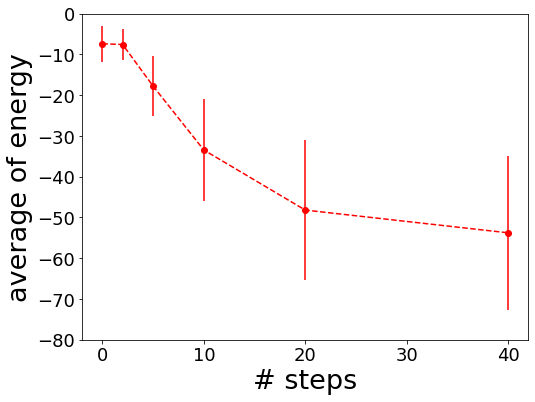

In [33]:
plot_energy_PGD_steps(model2, test_loader_imagenette, 8/255, [0,2,5,10,20,40], "/notebooks/Images/avg_energy.pdf")

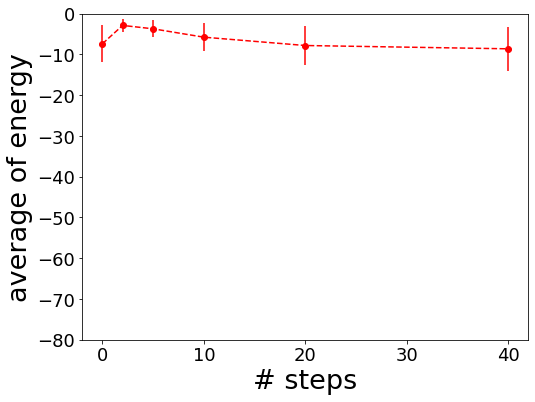

In [13]:
plot_energy_HEPGD_steps(model2, test_loader_imagenette, 8/255, [0,2,5,10,20,40], 1.2, "/notebooks/Images/avg_energyHE.pdf")

In [24]:
testing(model2, test_loader_imagenette)

100%|██████████| 123/123 [00:03<00:00, 36.42it/s]

Top1 accuracy of the network on the normal test set: 84.02547770700637
Top3 accuracy of the network on the normal test set: 94.90445859872611
Top5 accuracy of the network on the normal test set: 98.1656050955414


In [25]:
test_robustness_PGD(model2, test_loader_imagenette, epsilon=8/255, alpha=1/255, steps=0, printt=True)

Adv Accuracy: 3275/3925 (83%)



In [32]:
test_robustness_HEPGD(model2, test_loader_imagenette, epsilon=8/255, alpha=1/255, steps=10, factor=1.2, printt=True)

Adv Accuracy: 1/3925 (0%)



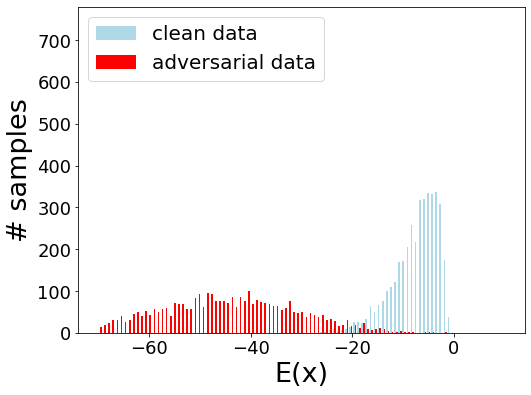

In [28]:
plot_energy_PGD(model2, test_loader_imagenette, epsilon=8/255, steps=20, bins=100, name="./Images/test_img.pdf")

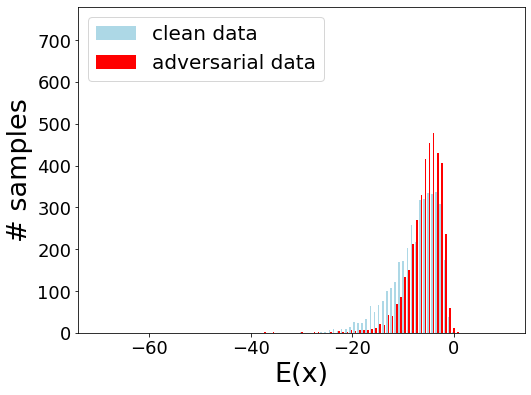

In [34]:
plot_energy_HEPGD(model2, test_loader_imagenette, epsilon=8/255, steps=10, bins=100, factor=1.2, name="./Images/test_img_HEPGD.pdf")